In [60]:
# Global imports and settings
from preamble import *
%matplotlib inline
#InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
interactive = False # Set to True for interactive plots 
if interactive:
    plt.rcParams['figure.dpi'] = 150
    table_font_size = '30px'
else:
    plt.rcParams['figure.dpi'] = 100
    table_font_size = '20px'

## Lecture 6. Data preprocessing

**Real-world machine learning pipelines**

Joaquin Vanschoren

## Data transformations

* Machine learning models make a lot of assumptions about the data
* In reality, these assumptions are often violated
* We build _pipelines_ that _transform_ the data before feeding it to the learners
    * Scaling (or other numeric transformations)
    * Encoding (convert categorical features into numerical ones)
    * Automatic feature selection
    * Feature engineering (e.g. binning, polynomial features,...)
    * Handling missing data
    * Handling imbalanced data
    * Dimensionality reduction (e.g. PCA)
    * Learned embeddings (e.g. for text)
* Seek the best combinations of transformations and learning methods
    * Often done empirically, using cross-validation
    * Make sure that there is no data leakage during this process!

## Scaling
* Use when different numeric features have different scales (different range of values)
    * Features with much higher values may overpower the others
* Goal: bring them all within the same range
* Different methods exist

In [48]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Iris dataset with some added noise
def noisy_iris():
    iris = fetch_openml("iris", return_X_y=True)
    X, y = iris
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, 150)
    for i in range(4):
        X[:, i] = X[:, i] + noise
    X[:, 0] = X[:, 0]+3 # add more skew 
    label_encoder = LabelEncoder().fit(y)
    y = label_encoder.transform(y)
    return X, y

scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer(norm='l1'), MaxAbsScaler()]

@interact
def plot_scaling(scaler=scalers):
    X, y = noisy_iris()
    X = X[:,:2] # Use only first 2 features
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    axes[0].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="brg")
    maxx = np.abs(X[:, 0]).max()
    maxy = np.abs(X[:, 1]).max()
    axes[0].set_xlim(-maxx + 1, maxx + 1)
    axes[0].set_ylim(-maxy + 1, maxy + 1)
    axes[0].set_title("Original Data")
    
    X_ = scaler.fit_transform(X)
    axes[1].scatter(X_[:, 0], X_[:, 1], c=y, s=10, cmap="brg")
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    axes[1].set_title(type(scaler).__name__)
    axes[1].set_xticks([-1,1])
    axes[1].set_yticks([-1,1])

    for ax in axes:
        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('center')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

interactive(children=(Dropdown(description='scaler', options=(StandardScaler(), RobustScaler(), MinMaxScaler()…

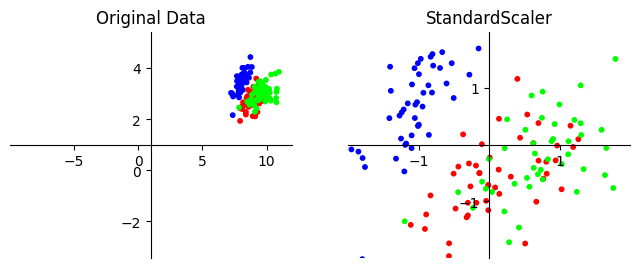

In [49]:
if not interactive:
    plot_scaling(scalers[0])

### Why do we need scaling?
* KNN: Distances depend mainly on feature with larger values
* SVMs: (kernelized) dot products are also based on distances
* Linear model: Feature scale affects regularization
    * Weights have similar scales, more interpretable

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# Example by Andreas Mueller, with some tweaks
def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1):
    # multiclass                                                                  
    if eps is None:                                                               
        eps = X.std(axis=0) / 2.
    else:
        eps = np.array([eps, eps])

    if ax is None:                                                                
        ax = plt.gca()                                                            

    x_min, x_max = X[:, 0].min() - eps[0], X[:, 0].max() + eps[0]
    y_min, y_max = X[:, 1].min() - eps[1], X[:, 1].max() + eps[1]
    # these should be 1000 but knn predict is unnecessarily slow
    xx = np.linspace(x_min, x_max, 100)                                          
    yy = np.linspace(y_min, y_max, 100)                                          

    X1, X2 = np.meshgrid(xx, yy)                                                  
    X_grid = np.c_[X1.ravel(), X2.ravel()]                                        
    decision_values = classifier.predict(X_grid)                                  
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,            
                                                       y_min, y_max),             
            aspect='auto', origin='lower', alpha=alpha, cmap=plt.cm.bwr)     

clfs = [KNeighborsClassifier(), SVC(), LinearSVC(), LogisticRegression(C=10)]

@interact
def plot_scaling_effect(classifier=clfs, show_test=[False,True]):
    X, y = make_blobs(centers=2, random_state=4, n_samples=50)
    X = X * np.array([1000, 1])
    y[7], y[27] = 0, 0 
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    
    clf2 = clone(classifier)
    clf_unscaled = classifier.fit(X_train, y_train)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[0].set_title("Without scaling. Accuracy:{:.2f}".format(clf_unscaled.score(X_test,y_test)))
    if show_test: # Hide test data for simplicity
        axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', cmap='bwr', label="test") 
        axes[0].legend()
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf_scaled = clf2.fit(X_train_scaled, y_train)

    axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='bwr', label="train")
    axes[1].set_title("With scaling. Accuracy:{:.2f}".format(clf_scaled.score(X_test_scaled,y_test)))   
    if show_test: # Hide test data for simplicity
        axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker='^', cmap='bwr', label="test")
        axes[1].legend()

    plot_2d_classification(clf_unscaled, X, ax=axes[0], alpha=.2)
    plot_2d_classification(clf_scaled, scaler.transform(X), ax=axes[1], alpha=.3)

interactive(children=(Dropdown(description='classifier', options=(KNeighborsClassifier(), SVC(), LinearSVC(), …

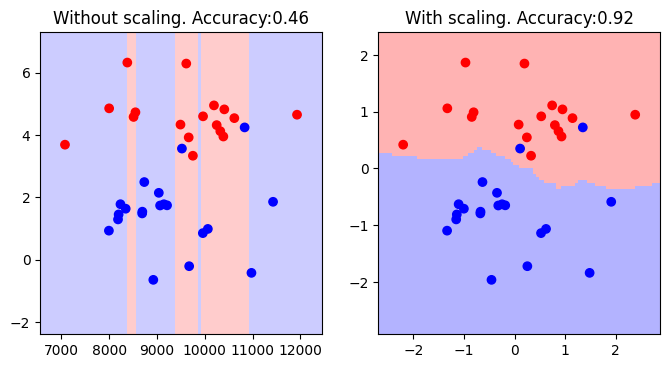

In [51]:
if not interactive:
    plot_scaling_effect(classifier=clfs[0], show_test=False)

### Standard scaling (standardization)
* Generally most useful, assumes data is more or less normally distributed
* Per feature, subtract the mean value $\mu$, scale by standard deviation $\sigma$
* New feature has $\mu=0$ and $\sigma=1$, values can still be arbitrarily large
$$\mathbf{x}_{new} = \frac{\mathbf{x} - \mu}{\sigma}$$

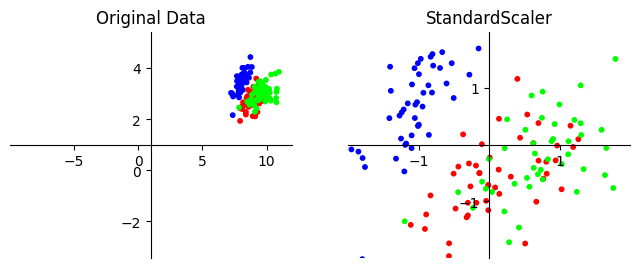

In [52]:
plot_scaling(scaler=StandardScaler())

### Min-max scaling
* Scales all features between a given $min$ and $max$ value (e.g. 0 and 1)
* Makes sense if min/max values have meaning in your data
* Sensitive to outliers

$$\mathbf{x}_{new} = \frac{\mathbf{x} - x_{min}}{x_{max} - x_{min}} \cdot (max - min) + min $$

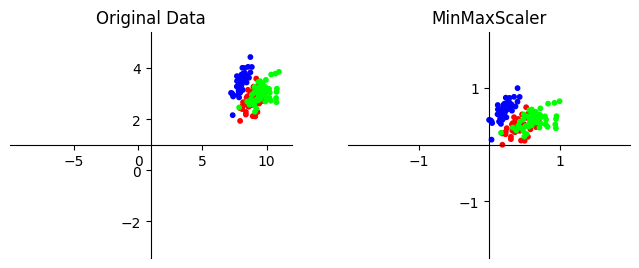

In [53]:
plot_scaling(scaler=MinMaxScaler(feature_range=(0, 1)))

### Robust scaling
* Subtracts the median, scales between quantiles $q_{25}$ and $q_{75}$
* New feature has median 0, $q_{25}=-1$ and $q_{75}=1$
* Similar to standard scaler, but ignores outliers

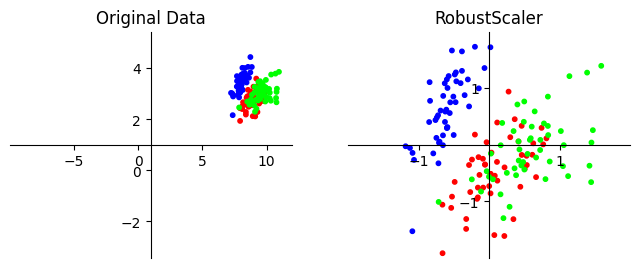

In [54]:
plot_scaling(scaler=RobustScaler())

### Normalization
* Makes sure that feature values of each point (each row) sum up to 1 (L1 norm)
    * Useful for count data (e.g. word counts in documents)
* Can also be used with L2 norm (sum of squares is 1)
    * Useful when computing distances in high dimensions
    * Normalized Euclidean distance is equivalent to cosine similarity 

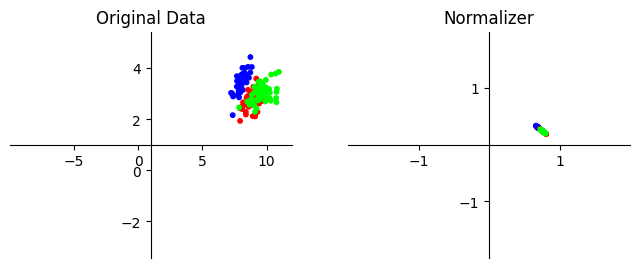

In [55]:
plot_scaling(scaler=Normalizer(norm='l1'))

### Maximum Absolute scaler
* For sparse data (many features, but few are non-zero)
    * Maintain sparseness (efficient storage)
* Scales all values so that maximum absolute value is 1
* Similar to Min-Max scaling without changing 0 values

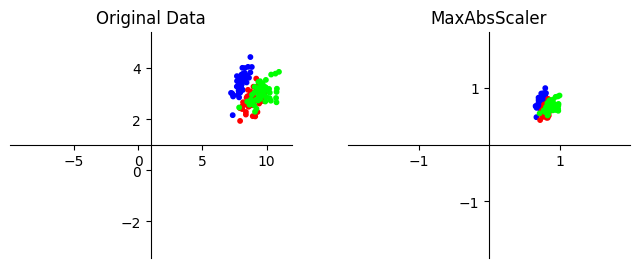

In [56]:
plot_scaling(scaler=MaxAbsScaler())

### Power transformations
* Some features follow certain distributions
    * E.g. number of twitter followers is log-normal distributed
* Box-Cox transformations transform these to normal distributions ($\lambda$ is fitted)
    * Only works for positive values, use Yeo-Johnson otherwise
$$bc_{\lambda}(x) = \begin{cases} log(x) & \lambda = 0\\ \frac{x^{\lambda}-1}{\lambda} & \lambda \neq 0 \\ \end{cases}$$

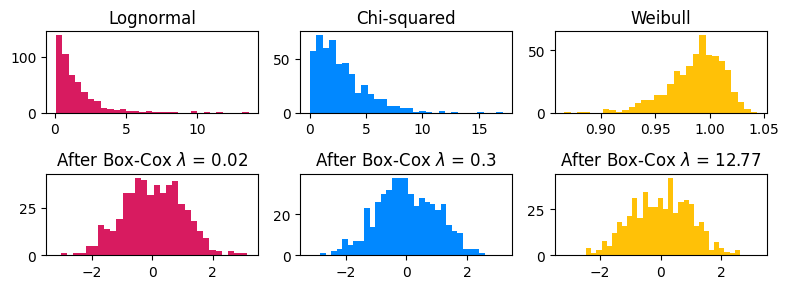

In [68]:
# Adapted from an example by Eric Chang and Nicolas Hug 
from sklearn.preprocessing import PowerTransformer

# Power transformer with Box-Cox
bc = PowerTransformer(method='box-cox')

# Generate data
rng = np.random.RandomState(304) # Random number generator
size = (1000, 1)
X_lognormal = rng.lognormal(size=size) # lognormal distribution
X_chisq = rng.chisquare(df=3, size=size) # chi-squared distribution
X_weibull = rng.weibull(a=50, size=size) # weibull distribution

# create plots
distributions = [
    ('Lognormal', X_lognormal),
    ('Chi-squared', X_chisq),
    ('Weibull', X_weibull)
]
colors = ['#D81B60', '#0188FF', '#FFC107']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 3))
axes = axes.flatten()
axes_idxs = [(0, 3), (1, 4), (2, 5)]
axes_list = [(axes[i], axes[j]) for (i, j) in axes_idxs]

for distribution, color, axes in zip(distributions, colors, axes_list):
    name, X = distribution
    X_train, X_test = train_test_split(X, test_size=.5)

    # perform power transforms and quantile transform
    X_trans_bc = bc.fit(X_train).transform(X_test)
    lmbda_bc = round(bc.lambdas_[0], 2)

    ax_original, ax_bc = axes
    ax_original.hist(X_train, color=color, bins=30)
    ax_original.set_title(name)
    ax_original.tick_params(axis='both', which='major')

    ax_bc.hist(X_trans_bc, color=color, bins=30)
    title = 'After {}'.format('Box-Cox')
    if lmbda_bc is not None:
        title += r' $\lambda$ = {}'.format(lmbda_bc)
    ax_bc.set_title(title)
    ax_bc.tick_params(axis='both', which='major')
    ax_bc.set_xlim([-3.5, 3.5])


plt.tight_layout()
plt.show()

In [61]:
heading_properties = [('font-size', table_font_size)]
cell_properties = [('font-size', table_font_size)]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

## Categorical feature encoding
* Many algorithms can only handle numeric features, so we need to encode the categorical ones

In [62]:
import pandas as pd
X = pd.DataFrame({'boro': ['Manhattan', 'Queens', 'Manhattan', 'Brooklyn', 'Brooklyn', 'Bronx'],
                   'salary': [103, 89, 142, 54, 63, 219]})
y = pd.DataFrame({'vegan': [0, 0, 0, 1, 1, 0]})
df = X.copy()
df['vegan'] = y
df.style.set_table_styles(dfstyle)

,boro,salary,vegan
0,Manhattan,103,0
1,Queens,89,0
2,Manhattan,142,0
3,Brooklyn,54,1
4,Brooklyn,63,1
5,Bronx,219,0


### Ordinal encoding
* Simply assigns an integer value to each category in the order they are encountered
* Only really useful if there exist a natural order in categories
    * Model will consider one category to be 'higher' or 'closer' to another

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype=int)

# Encode first feature, rest passthrough
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0])], remainder='passthrough')
X_ordinal = preprocessor.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=X_ordinal, columns=["boro_ordinal","salary"])
df = pd.concat([X['boro'], df], axis=1)
df.style.set_table_styles(dfstyle)

,boro,boro_ordinal,salary
0,Manhattan,2,103
1,Queens,3,89
2,Manhattan,2,142
3,Brooklyn,1,54
4,Brooklyn,1,63
5,Bronx,0,219


### One-hot encoding (dummy encoding)
* Simply adds a new 0/1 feature for every category, having 1 (hot) if the sample has that category
* Can explode if a feature has lots of values, causing issues with high dimensionality
* What if test set contains a new category not seen in training data?
    * Either ignore it (just use all 0's in row), or handle manually (e.g. resample) 

In [64]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(dtype=int)

# Encode first feature, rest passthrough
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0])], remainder='passthrough')
X_ordinal = preprocessor.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=X_ordinal, columns=["boro_Bronx","boro_Brooklyn","boro_Manhattan","boro_Queens","salary"])
df = pd.concat([X['boro'], df], axis=1)
df.style.set_table_styles(dfstyle)

,boro,boro_Bronx,boro_Brooklyn,boro_Manhattan,boro_Queens,salary
0,Manhattan,0,0,1,0,103
1,Queens,0,0,0,1,89
2,Manhattan,0,0,1,0,142
3,Brooklyn,0,1,0,0,54
4,Brooklyn,0,1,0,0,63
5,Bronx,1,0,0,0,219


### Target encoding
* Value close to 1 if category correlates with class 1, close to 0 if correlates with class 0
* Blends posterior probability of the target $\frac{n_{iY}}{n_i}$ and prior probability $\frac{n_Y}{n}$.
    * $n_{iY}$: nr of samples with category i and class Y=1, $n_{i}$: nr of samples with category i

    * Blending is done using the logit function (S-curve)
$$Enc(i) = \color{blue}{\frac{1}{1+e^{-(n_i-1)}} \frac{n_{iY}}{n_i}} + \color{green}{(1-\frac{1}{1+e^{-(n_i-1)}}) \frac{n_Y}{n}}$$
    * Same for regression, using $\frac{n_{iY}}{n_i}$: average target value with category i, $\frac{n_{Y}}{n}$: overall mean
* Preferred when you have lots of category values. It only creates a few new features (1 per class)

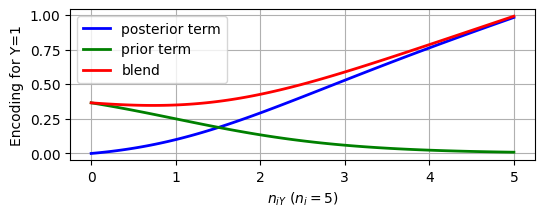

In [65]:
# smoothed sigmoid
def sigmoid(x, smoothing=1):
    return 1 / (1 + np.exp(-(x-1)/smoothing))

def plot_blend():
    n = 20 # 20 points
    ny = 10 # 10 points of class Yes
    ni = 5 # max 5 points of category i
    niy = np.linspace(0,ni,100) # number of points of category i and class Yes
    
    fig, ax = plt.subplots(figsize=(6,2))

    ax.plot(niy,sigmoid(niy)*(niy/ni),lw=2,c='b',label='posterior term', linestyle='-')
    ax.plot(niy,(1-sigmoid(niy))*(ny/n),lw=2,c='g',label='prior term', linestyle='-')
    ax.plot(niy,sigmoid(niy)*(niy/ni) + (1-sigmoid(niy))*(ny/n),lw=2,c='r',label='blend', linestyle='-')
    ax.set_xlabel(r"$n_{iY}$ ($n_i = 5$)")
    ax.set_ylabel("Encoding for Y=1")
    plt.grid()
    plt.legend();
plot_blend()

#### Example:
* For Brooklyn, $n_{iY}=2, n_{i}=2, n_{Y}=2, n=6$ 
* Would be closer to 1 if there were more examples, all with label 1
$$Enc(Brooklyn) = \frac{1}{1+e^{-1}} \frac{2}{2} + (1-\frac{1}{1+e^{-1}}) \frac{2}{6}  = 0,82$$


In [66]:
# Not in sklearn yet, use package category_encoders
# !pip install category_encoders
from category_encoders import TargetEncoder

encoder = TargetEncoder(return_df=True)
encoder.fit(X, y)
pd_te = encoder.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=pd_te, columns=["boro","salary"]).rename(columns={'boro': 'boro_encoded'})
df = pd.concat([X['boro'], df, y], axis=1)
df.style.set_table_styles(dfstyle)

,boro,boro_encoded,salary,vegan
0,Manhattan,0.09,103,0
1,Queens,0.33,89,0
2,Manhattan,0.09,142,0
3,Brooklyn,0.82,54,1
4,Brooklyn,0.82,63,1
5,Bronx,0.33,219,0


## Applying data transformations
* Data transformations should always follow a fit-predict paradigm
    * Fit the transformer on the training data only
        * E.g. for a standard scaler: record the mean and standard deviation
    * Transform (e.g. scale) the training data, then train the learning model
    * Transform (e.g. scale) the test data, then evaluate the model
* Only scale the input features (X), not the targets (y)
* If you fit and transform the whole dataset before splitting, you get data leakage
    * You have looked at the test data before training the model
    * Model evaluations will be misleading
* If you fit and transform the training and test data separately, you distort the data
    * E.g. training and test points are scaled differently

### In practice (scikit-learn)

``` python
# choose scaling method and fit on training data
scaler = StandardScaler()
scaler.fit(X_train)

# transform training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

``` python
# calling fit and transform in sequence
X_train_scaled = scaler.fit(X_train).transform(X_train)
# same result, but more efficient computation
X_train_scaled = scaler.fit_transform(X_train)
```

### Test set distortion example
* Properly scaled: `fit` on training set, `transform` on training and test set
* Improperly scaled: `fit` and `transform` on the training and test data separately
    * Test data points nowhere near same training data points

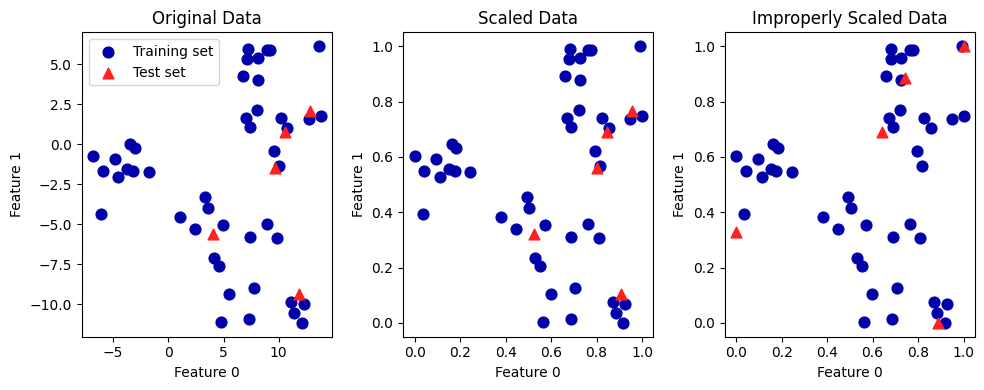

In [67]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

from sklearn.datasets import make_blobs
# make synthetic data
X, _ = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)
# split it into training and test set
X_train, X_test = train_test_split(X, random_state=5, test_size=.1)

# plot the training and test set
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].scatter(X_train[:, 0], X_train[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[0].scatter(X_test[:, 0], X_test[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[0].legend(loc='upper left')
axes[0].set_title("Original Data")

# scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# visualize the properly scaled data
axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="Training set", s=60)
axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], marker='^',
                c=mglearn.cm2(1), label="Test set", s=60)
axes[1].set_title("Scaled Data")

# rescale the test set separately
# so that test set min is 0 and test set max is 1
# DO NOT DO THIS! For illustration purposes only
test_scaler = MinMaxScaler()
test_scaler.fit(X_test)
X_test_scaled_badly = test_scaler.transform(X_test)

# visualize wrongly scaled data
axes[2].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1],
                c=mglearn.cm2(0), label="training set", s=60)
axes[2].scatter(X_test_scaled_badly[:, 0], X_test_scaled_badly[:, 1],
                marker='^', c=mglearn.cm2(1), label="test set", s=60)
axes[2].set_title("Improperly Scaled Data")

for ax in axes:
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
fig.tight_layout()

### Data leakage example
* Cross-validation: training set is split into training and validation sets for model selection
* Incorrect: Scaler is fit on whole training set before doing cross-validation
    * Data leaks from validation folds into training folds, selected model may be optimistic
* Right: Scaler is fit on training folds only

<img src="../images/infoleak.png" alt="ml" style="width: 1500px;"/>

## Pipelines
* A pipeline is a combination of data transformation and learning algorithms
* It has a `fit`, `predict`, and `score` method, just like any other learning algorithm
    * Ensures that data transformations are applied correctly
    
<img src="../images/07_pipelines.png" alt="ml" style="width: 600px;"/>

### In practice (scikit-learn)
* A `pipeline` combines multiple processing _steps_ in a single estimator
* All but the last step should be data transformer (have a `transform` method)

``` python
# Make pipeline, step names will be 'minmaxscaler' and 'linearsvc'
pipe = make_pipeline(MinMaxScaler(), LinearSVC())
# Build pipeline with named steps 
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC())])

# Correct fit and score
score = pipe.fit(X_train, y_train).score(X_test, y_test)
# Retrieve trained model by name
svm = pipe.named_steps["svm"]
```

``` python
# Correct cross-validation
scores = cross_val_score(pipe, X, y)
```

### In practice (scikit-learn), continued
* If you want to apply different preprocessors to different columns, use `ColumnTransformer`
* If you want to merge pipelines, you can use `FeatureUnion` to concatenate columns

``` python
# 2 sub-pipelines, one for numeric features, other for categorical ones
numeric_pipe = make_pipeline(SimpleImputer(),StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(),OneHotEncoder())

# Using categorical pipe for features A,B,C, numeric pipe otherwise
preprocessor = make_column_transformer((categorical_pipe,["A","B","C"]), 
                                       remainder=numeric_pipe)

# Combine with learning algorithm in another pipeline
pipe = make_pipeline(preprocess, LinearSVC())
```

``` python
# Feature union of PCA features and selected features
union = FeatureUnion([("pca", PCA()), ("selected", SelectKBest())])
pipe = make_pipeline(union, LinearSVC())
```

### In practice (scikit-learn), continued
* `ColumnTransformer` concatenates features in order

``` python
pipe = make_column_transformer((StandardScaler(),numeric_features), 
                               (PCA(),numeric_features),  
                               (OneHotEncoder(),categorical_features))
```

<img src="../images/columntransformer.png" alt="ml" style="width: 900px;"/>

### Model selection (scikit-learn)
* We can safely use pipelines in model selection (e.g. grid search)
* Use `'__'` to refer to the hyperparameters of a step, e.g. `svm__C`

``` python
# Correct grid search (can have hyperparameters of any step)
param_grid = {'svm__C': [0.001, 0.01],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X,y)
# Best estimator is now the best pipeline
best_pipe = grid.best_estimator_

# Tune pipeline and evaluate on held-out test set
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X_train,y_train)
grid.score(X_test,y_test)

```

#### Example: Tune multiple steps at once
``` python
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(), Ridge())
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid).fit(X_train, y_train)
```

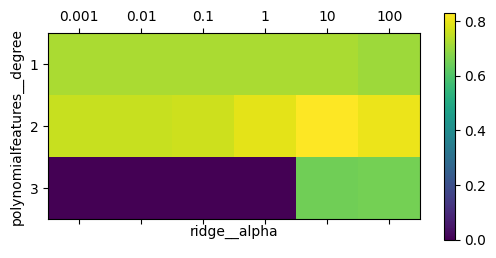

In [19]:
from sklearn.datasets import load_boston
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train);

#plot
fig, ax = plt.subplots(figsize=(6, 3))
im = ax.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
ax.set_xlabel("ridge__alpha")
ax.set_ylabel("polynomialfeatures__degree")
ax.set_xticks(range(len(param_grid['ridge__alpha'])))
ax.set_xticklabels(param_grid['ridge__alpha'])
ax.set_yticks(range(len(param_grid['polynomialfeatures__degree'])))
ax.set_yticklabels(param_grid['polynomialfeatures__degree'])
plt.colorbar(im);

## Automatic Feature Selection

It can be a good idea to reduce the number of features to only the most useful ones
- Simpler models that generalize better (less overfitting)
    - Even models such as RandomForest can benefit from this
- Help algorithms that are sensitive to the curse of dimensionality
    - e.g. kNN and many other distance-based methods
- Sometimes it is one of the main methods to improve models (e.g. gene expression data)

##### Example: Iris
Below are the distributions (histograms) of every class according to every feature.  
Which of the four features is most informative?

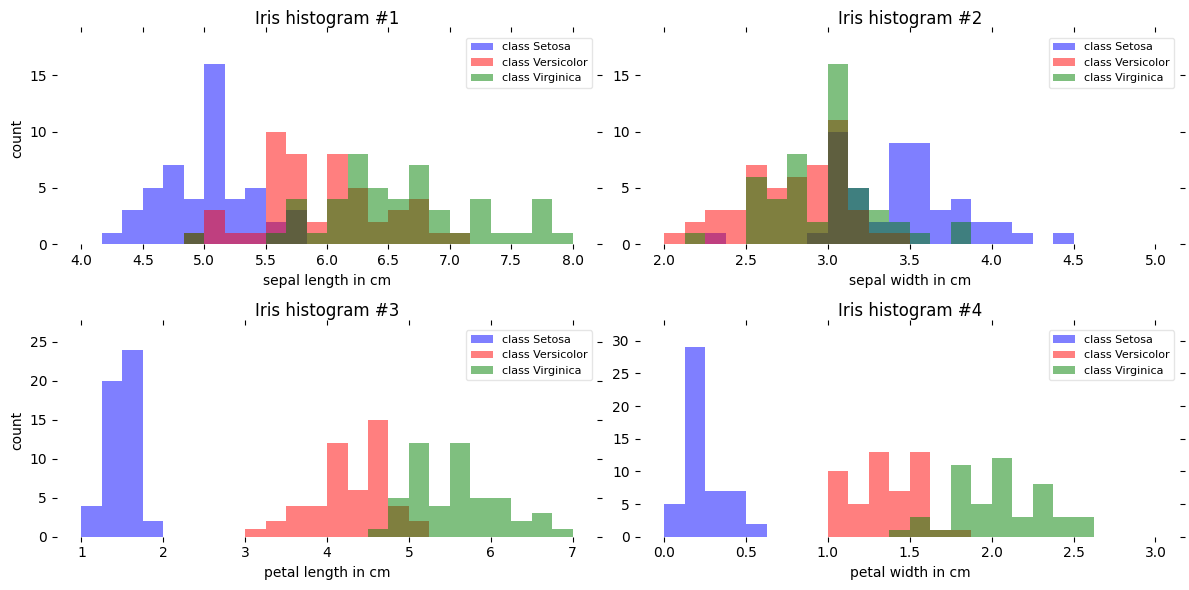

In [20]:
import math
from sklearn.datasets import load_iris

iris_dataset = load_iris()

X = iris_dataset['data']
y = iris_dataset['target']+1
label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

### Univariate statistics

* Keep features for which there is a __statistically significant relationship__ between it and the target.
* Consider each feature individually (univariate), independent of the model that you might want to apply afterwards.
* We can use different tests to measure how informative a feature is: 

`f_regression`: For numeric targets. Measures the performance of a linear regression model trained on only one feature.

`f_classif`: For categorical targets. Measures the _F-statistic_ from one-way Analysis of Variance (ANOVA), or the proportion of total within-class variance explained by one feature.

`chi2`: For categorical features and targets. Performs the chi-square ($\chi^2$) statistic. Similar results as F-statistic, but less sensitive to nonlinear relationships.

* Both the F-statistic and $\chi^2$ methods use the p-value under the F- and $\chi^2$ distribution, respectively.
* F-statistic = $\frac{var(\mu_i)}{\overline{var}(X_i)}$ (higher is better)  
    * $X_i$: all samples with class i.  
    * Better if per-class distributions separate well: means are far apart and variance is small.

<img src="../images/03_fstatistic.png" alt="ml" style="width: 500px;"/>

Chi-squared for a feature with $c$ categories and $k$ classes:

$$\chi^2 = \sum_{i=0}^{c} \sum_{j=0}^{k} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

where $O_{ij}$ is the number of observations of feature category $i$ and class $j$, and $E_{ij}$ is the expected number of observations of category $i$ and class $j$ if there was no relationship between the feature and the target (number of samples of category $i$ * ratio of class $j$).


In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)

#### In practice

* Given a feature ranking, sklearn has two general ways to remove features :
- `SelectKBest` will only keep the $k$ features with the lowest p values. 
- `SelectPercentile` selects a fixed percentage of features. 
* Retrieve the selected features with `get_support()`

Visualization: 
* Classification dataset with 30 real features, and add 50 random noise features.  
    * Ideally, the feature selection removes at least the last 50 noise features.  
* Selected features in black, removed features in white
* Results for `SelectPercentile` with `f_classif` (ANOVA):
    * OK, but fails to remove several noise features

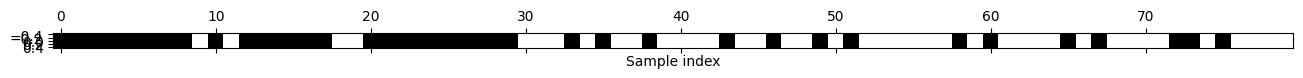

In [22]:
# use f_classif (the default) and SelectPercentile to select 50% of features:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set:
X_train_selected = select.transform(X_train)

mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

Impact on performance: check how the transformation affects the performance of our learning algorithms.

In [23]:
from sklearn.linear_model import LogisticRegression

# transform test data:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("LogisticRegression score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("LogisticRegression score with only selected features: {:.3f}".format(
        lr.score(X_test_selected, y_test)))

LogisticRegression score with all features: 0.916
LogisticRegression score with only selected features: 0.919


### Model-based Feature Selection
Model-based feature selection uses a supervised machine learning model to judge the importance of each feature, and keeps only the most important ones. They consider all features together, and are thus able to capture interactions: a feature may be more (or less) informative in combination with others.

The supervised model that is used for feature selection doesn’t need to be the same model that is used for the final supervised modeling, it only needs to be able to measure the (perceived) importance for each feature:

- Decision tree–based models return a `feature_importances_` attribute
- Linear models return coefficients (`coef_`), whose absolute values also reflect feature importance 

In scikit-learn, we can do this using `SelectFromModel`. It requires a model and a threshold. Threshold='median' means that the median observed feature importance will be the threshold, which will remove 50% of the features.
```
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")
```

* Random Forests are known to produce good estimates of feature importance
    * Based on how often a feature is used high up in the trees
    * Based on Information Gain or Mean Decrease in Impurity (MDI)
    * Use with care: [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
    * Tune the RandomForest (e.g. `min_samples_leaf`)
    * Use permutation importance (coming up)
* In our example, all but two of the original features were selected, and most of the noise features removed.
* Our logistic regression model improves further

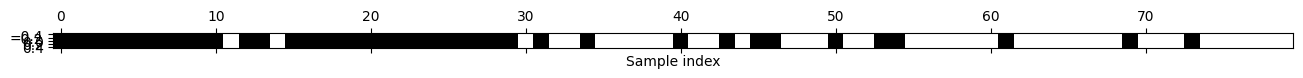

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

In [25]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("LogisticRegression test score: {:.3f}".format(score))

LogisticRegression test score: 0.930


### Iterative feature selection

Instead of building a model to remove many features at once, we can also just ask it to remove the worst feature, then retrain, remove another feature, etc. This is known as _recursive feature elimination_ (RFE).
```
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)
```

Vice versa, we could also ask it to iteratively add one feature at a time. This is called _forward selection_.

In both cases, we need to define beforehand how many features to select. When this is unknown, one often considers this as an additional hyperparameter of the whole process (pipeline) that needs to be optimized.

Can be rather slow.

RFE result:
* Fewer noise features, only 1 original feature removed
* LogisticRegression performance about the same

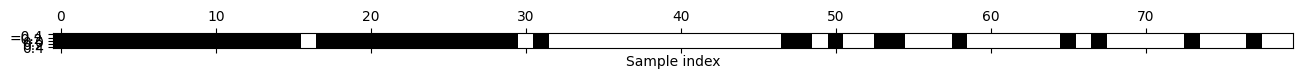

In [26]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index");

In [27]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("LogisticRegression Test score: {:.3f}".format(score))

LogisticRegression Test score: 0.930


### Permutation feature importance

* Model inspection technique, especially useful for non-linear or opaque estimators. 
* Defined as **the decrease in a model score when a single feature value is randomly shuffled**.
* This breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 
* Model agnostic, metric agnostic, and can be calculated many times with different permutations.
* The problem with impurity based techniques (e.g. Random Forest)
    * Gives importance to features not predictive on unseen data. 
        * Permutation feature importance can be applied to unseen data.
    * Strong bias towards high cardinality features (e.g. numerical features).
        * Permutation feature importances do not exhibit such a bias. 

##### Example (Titanic dataset)
* We add a random feature as well: Random Forest deems it important!
* Low cardinality feature `sex` and `pclass` are actually more important
* Note: this requires the development version of sklearn

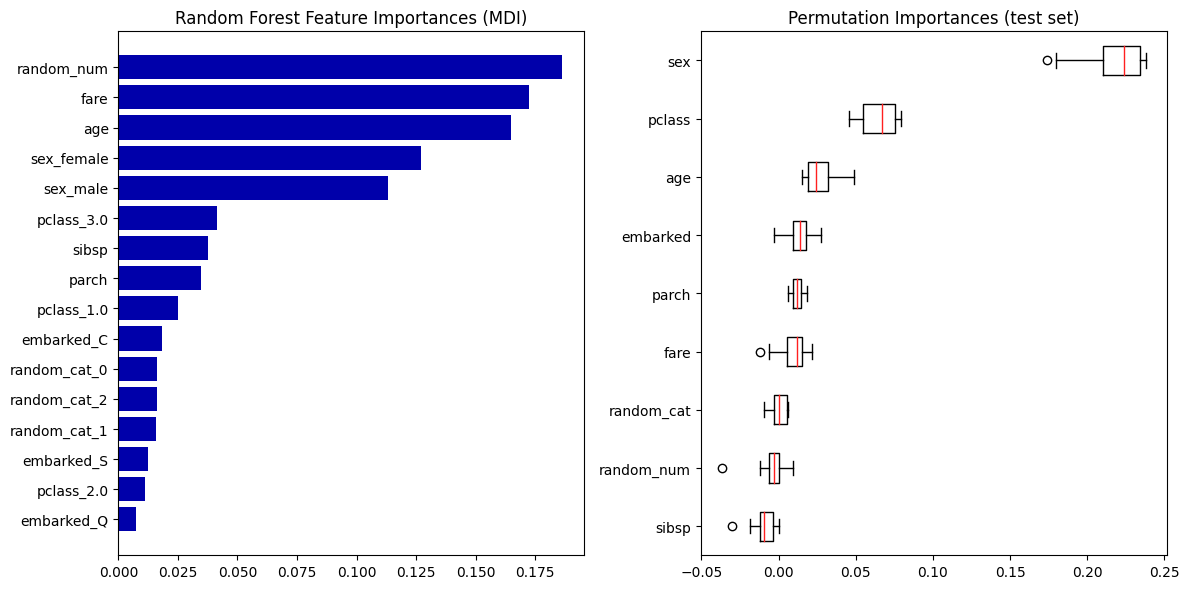

In [28]:
# Example from https://scikit-learn.org/dev/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

#RF based importances
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
y_ticks = np.arange(0, len(feature_names))
ax[0].barh(y_ticks, tree_feature_importances[sorted_idx])
ax[0].set_yticklabels(feature_names[sorted_idx])
ax[0].set_yticks(y_ticks)
ax[0].set_title("Random Forest Feature Importances (MDI)")

result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[1].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax[1].set_title("Permutation Importances (test set)")

fig.tight_layout()
plt.show()

We can also compute the permutation importances on the training set. 
* `random_num` gets a significantly higher importance ranking than when computed on the test set.
* This shows that the RF model has enough capacity to use that random numerical feature to overfit.

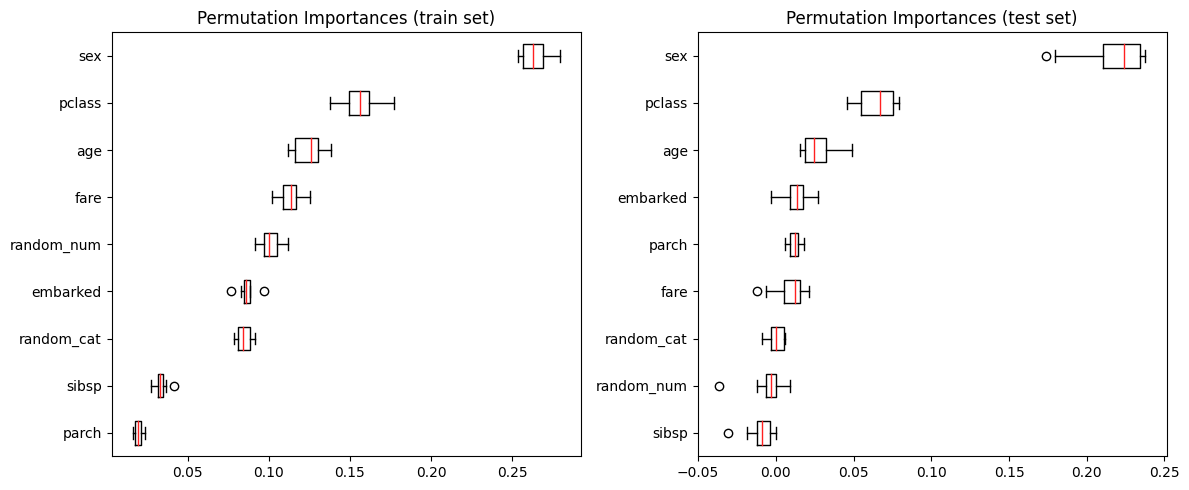

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[1].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax[1].set_title("Permutation Importances (test set)")


result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[0].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax[0].set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

Let's rerun this with a more regularized Random Forest (`min_samples_leaf=10`):

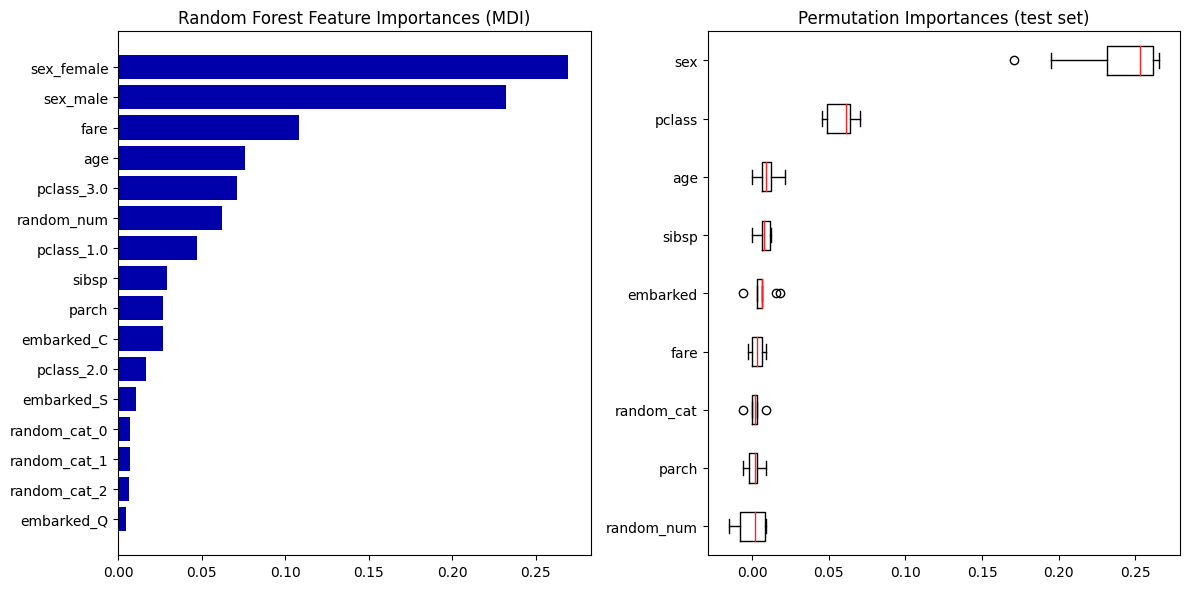

In [30]:
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42, min_samples_leaf=10))
])
rf.fit(X_train, y_train)

#RF based importances
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
y_ticks = np.arange(0, len(feature_names))
ax[0].barh(y_ticks, tree_feature_importances[sorted_idx])
ax[0].set_yticklabels(feature_names[sorted_idx])
ax[0].set_yticks(y_ticks)
ax[0].set_title("Random Forest Feature Importances (MDI)")

result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

ax[1].boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax[1].set_title("Permutation Importances (test set)")

fig.tight_layout()
plt.show()

### Feature selection wrap-up

Automatic feature selection can be helpful when:

- You expect some inputs to be uninformative
- Your model does not select features internally (as tree-based models do)
    - Even then it may help
- You need to speed up prediction without loosing much accuracy
- You want a more interpretable model (with fewer variables)

## Feature Engineering
* Create new features based on existing ones
    * Polynomial features
    * Interaction features
    * Binning
* Mainly useful for simple models (e.g. linear models)
    * Other models can learn interations themselves
    * But may be slower, less robust than linear models

### Polynomials
* Add all polynomials up to degree $d$ and all products
    * Equivalent to polynomial basis expansions
$$[1, x_1, ..., x_p] \xrightarrow{} [1, x_1, ..., x_p, x_1^2, ..., x_p^2, ..., x_p^d, x_1 x_2, ..., x_{p-1} x_p]$$


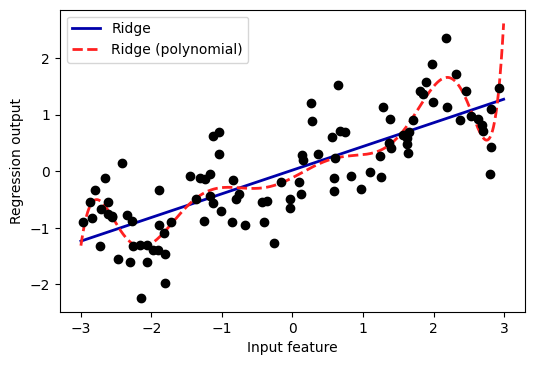

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

# Wavy data
X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

# Normal ridge
lreg = Ridge().fit(X, y)
plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")

# include polynomials up to x ** 10
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X)
preg = Ridge().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, preg.predict(line_poly), lw=2, label='Ridge (polynomial)')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Binning
- Partition numeric feature values into $n$ intervals (bins)
- Create $n$ new one-hot features, 1 if original value falls in corresponding bin
- Models different intervals differently (e.g. different age groups)

In [32]:
from sklearn.preprocessing import OneHotEncoder

# create 11 equal bins
bins = np.linspace(-3, 3, 5)
# assign to bins
which_bin = np.digitize(X, bins=bins)
# transform using the OneHotEncoder.
encoder = OneHotEncoder(sparse=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
# Plot transformed data
bin_names = [('[%.1f,%.1f]') % i for i in zip(bins, bins[1:])]
df_orig = pd.DataFrame(X, columns=["orig"])
df_nr = pd.DataFrame(which_bin, columns=["which_bin"])
# add the original features
X_combined = np.hstack([X, X_binned])
pd.DataFrame(X_combined, columns=["orig"]+bin_names).head(3)

,orig,"[-3.0,-1.5]","[-1.5,0.0]","[0.0,1.5]","[1.5,3.0]"
0,-0.75,0.0,1.0,0.0,0.0
1,2.70,0.0,0.0,0.0,1.0
2,1.39,0.0,0.0,1.0,0.0


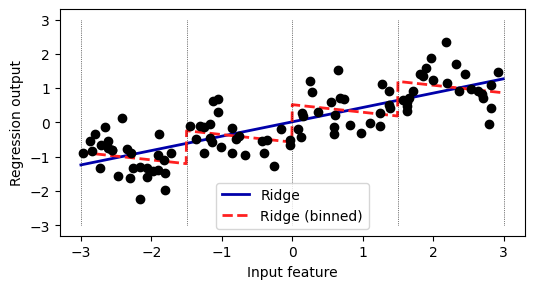

In [33]:
line_binned = encoder.transform(np.digitize(line, bins=bins))
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])

plt.rcParams['figure.figsize'] = [6, 3]
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")
plt.plot(line, reg.predict(line_combined), lw=2, label='Ridge (binned)')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k');

### Binning + interaction features
* Add _interaction features_ (or _product features_)
    * Product of the bin encoding and the original feature value
    * Learn different weights per bin

In [34]:
X_product = np.hstack([X_binned, X * X_binned])
bin_sname = ["b" + str(s) for s in range(4)] 
X_combined = np.hstack([X, X_product])
pd.set_option('display.max_columns', 10)
pd.DataFrame(X_combined, columns=["orig"]+bin_sname+["X*" + s for s in bin_sname]).head(3)

,orig,b0,b1,b2,b3,X*b0,X*b1,X*b2,X*b3
0,-0.75,0.0,1.0,0.0,0.0,-0.0,-0.75,-0.00,-0.0
1,2.70,0.0,0.0,0.0,1.0,0.0,0.00,0.00,2.7
2,1.39,0.0,0.0,1.0,0.0,0.0,0.00,1.39,0.0


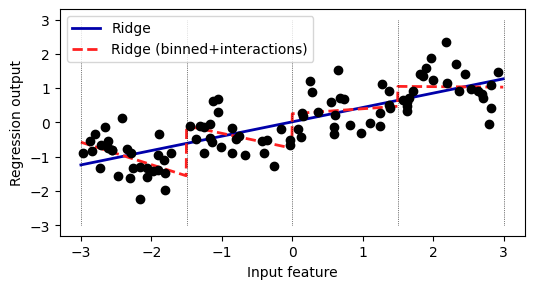

In [35]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")
plt.plot(line, reg.predict(line_product), lw=2, label='Ridge (binned+interactions)')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Categorical feature interactions
* One-hot-encode categorical feature
* Multiply every one-hot-encoded column with every numeric feature
* Allows to built different submodels for different categories

In [36]:
df = pd.DataFrame({'gender': ['M', 'F', 'M', 'F', 'F'],
                   'age': [14, 16, 12, 25, 22],
                   'pageviews': [70, 12, 42, 64, 93],
                   'time_online': [269, 1522, 235, 63, 21]
                  })
df.head(3)

,gender,age,pageviews,time_online
0,M,14,70,269
1,F,16,12,1522
2,M,12,42,235


In [37]:
dummies = pd.get_dummies(df)
df_f = dummies.multiply(dummies.gender_F, axis='rows')
df_f = df_f.rename(columns=lambda x: x + "_F")
df_m = dummies.multiply(dummies.gender_M, axis='rows')
df_m = df_m.rename(columns=lambda x: x + "_M")
res = pd.concat([df_m, df_f], axis=1).drop(["gender_F_M", "gender_M_F"], axis=1)
res.head(3)

,age_M,pageviews_M,time_online_M,gender_M_M,age_F,pageviews_F,time_online_F,gender_F_F
0,14,70,269,1,0,0,0,0
1,0,0,0,0,16,12,1522,1
2,12,42,235,1,0,0,0,0


## Missing value imputation
* Many sci-kit learn algorithms cannot handle missing value
* `Imputer` replaces specific values
    * `missing_values` (default 'NaN') placeholder for the missing value
    * `strategy`:
        - `mean`, replace using the mean along the axis
        - `median`, replace using the median along the axis
        - `most_frequent`, replace using the most frequent value
* Many more advanced techniques exist, but not yet in scikit-learn
    * e.g. low rank approximations (uses matrix factorization)

``` python
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit_transform(X1_train)
```

In [38]:
from sklearn.impute import SimpleImputer
X1_train = [[1, 2], [np.nan, 3], [7, np.nan]];
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X1 = [[np.nan, 2], [6, np.nan], [7, 6]]
print("Missing data:\n {}".format(np.array(X1_train) ))                          
print("Imputed data:\n {}".format(imp.fit_transform(X1_train))  ) 

Missing data:
 [[ 1.  2.]
 [nan  3.]
 [ 7. nan]]
Imputed data:
 [[1.  2. ]
 [4.  3. ]
 [7.  2.5]]


In [39]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Iris dataset with some added noise
def noisy_iris():
    iris = fetch_openml("iris", return_X_y=True)
    X, y = iris
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, 150)
    for i in range(4):
        X[:, i] = X[:, i] + noise
    X[:, 0] = X[:, 0]+3 # add more skew 
    label_encoder = LabelEncoder().fit(y)
    y = label_encoder.transform(y)
    return X, y

scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer(norm='l1'), MaxAbsScaler()]

@interact
def plot_scaling(scaler=scalers):
    X, y = noisy_iris()
    X = X[:,:2] # Use only first 2 features
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    axes[0].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="brg")
    maxx = np.abs(X[:, 0]).max()
    maxy = np.abs(X[:, 1]).max()
    axes[0].set_xlim(-maxx + 1, maxx + 1)
    axes[0].set_ylim(-maxy + 1, maxy + 1)
    axes[0].set_title("Original Data")
    
    X_ = scaler.fit_transform(X)
    axes[1].scatter(X_[:, 0], X_[:, 1], c=y, s=10, cmap="brg")
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    axes[1].set_title(type(scaler).__name__)
    axes[1].set_xticks([-1,1])
    axes[1].set_yticks([-1,1])

    for ax in axes:
        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('center')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

interactive(children=(Dropdown(description='scaler', options=(StandardScaler(), RobustScaler(), MinMaxScaler()…

## Handling imbalanced data
* Randomly oversample the minority class
    * Sample the same points over and over again
* Randomly undersample the majority class
    * Faster, but may lose information
* Add class weights to the classifier loss function
    * Contribution of every wrongly predicted point is weighted by its class's imbalance 
    * Most algorithms allow this (`class_weight` hyperparameter)
* Ensemble resampling
    * Create an ensemble by iteratively applying random under-sampling


## Handling imbalanced data
* Edited Nearest Neighbors
    * Remove all majority samples that are misclassified by KNN (mode) or that have a neighbor from the other class (all).
    * Remove their influence on the minority samples
* Condensed Nearest Neighbors
    * Remove all majority samples that are _not_ misclassified by KNN
    * Focus on only the hard samples.
* Synthetic Minority Oversampling Technique (SMOTE)
    * Choose a minority point and a neighboring minority point
    * Add a new, artificial point on the line between them
    * May bias the data. Be careful never to use artificial points in the test set.

## Handling imbalanced data in practice
* http://imbalanced-learn.org
* Always build _pipelines_ of a sampler and a learner
    * The test set should never be affected by resampling
* Methods:
    * RandomUnderSampler
    * RandomOverSampler
    * BalancedBaggingClassifier
    * EditedNearestNeighbours
    * CondensedNearestNeighbour
    * SMOTE

Comparison

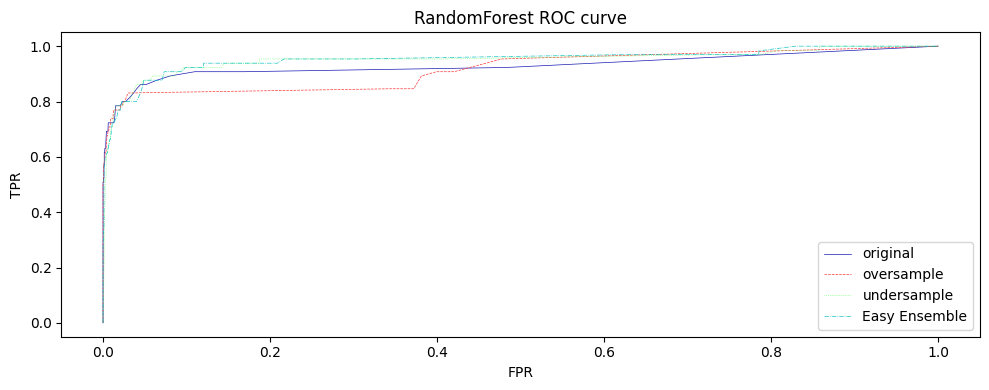

In [40]:
# mammography dataset https://www.openml.org/d/310
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

data = fetch_openml('mammography')
X, y = data.data, data.target
y = (y.astype(np.int) + 1) // 2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(n_estimators=100))
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators=100))

resampled_rf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                                         n_estimators=100, random_state=0)

oversample_pipe_rf.fit(X_train, y_train)
probs_oversample = oversample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)

undersample_pipe_rf.fit(X_train, y_train)
probs_undersample = undersample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)

resampled_rf.fit(X_train, y_train)
probs_easy_ensemble = resampled_rf.predict_proba(X_test)[:, 1]
fpr_ee, tpr_ee, _ = roc_curve(y_test, probs_easy_ensemble)

rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
probs_original = rf.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)

fig, axes = plt.subplots(figsize=(10, 4))
axes.plot(fpr_org, tpr_org, label="original", alpha=.9)
axes.plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes.plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes.plot(fpr_ee, tpr_ee, label="Easy Ensemble", alpha=.9)
axes.legend()
axes.set_xlabel("FPR")
axes.set_ylabel("TPR")
axes.set_title("RandomForest ROC curve")

plt.tight_layout()

SMOTE

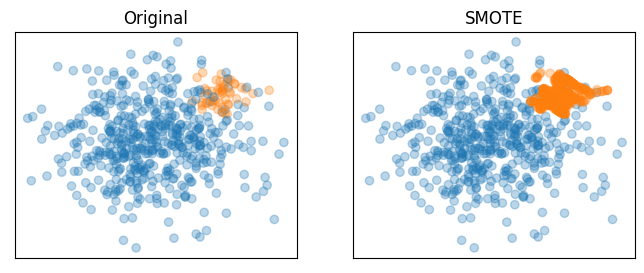

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
smote = SMOTE()

rng = np.random.RandomState(0)
n_samples_1 = 500
n_samples_2 = 50
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn, y_syn = shuffle(X_syn, y_syn)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
fig, axes = plt.subplots(1, 2, figsize=(8, 3), subplot_kw={'xticks':(), 'yticks':()})
axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=plt.cm.tab10(y_syn), alpha=.3)
axes[1].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.tab10(y_resampled), alpha=.3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE");

## Summary

* Transforming the features can drastically impact performance
    - Constructing new features makes linear models more powerful
    - Selecting features can reduce overfitting and improve performance
    - Scaling is important for many distance-based methods (e.g. kNN, SVM)
* Pipelines allow us to encapsulate multiple steps into a single estimator
    - Has `fit`, `transform`, and `predict` methods
* Avoids data leakage, hence crucial for proper evaluation
* Choosing the right combination of feature extraction, preprocessing, and models is somewhat of an art.
* Pipelines + Grid/Random Search help, but search space is huge
    - Smarter techniques are being researched (see later)
* Real world applications require careful thought, prototyping, and tireless evaluation.   